# Crop Recommendation System using Deep Learning
This project aims to build a deep learning model to recommend the most suitable crop to grow based on environmental conditions like soil nutrients and climate. The goal is to assist farmers in making informed agricultural decisions.


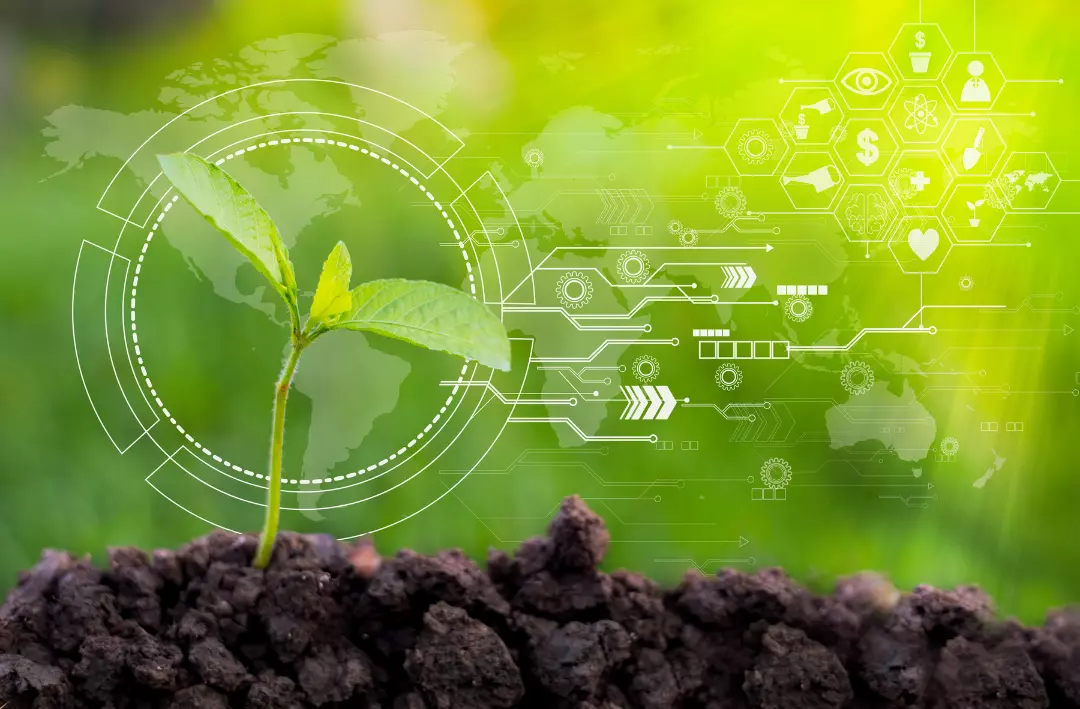

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## 1. Dataset Overview
The dataset used in this project is publicly available on Kaggle:
[Crop Recommendation Dataset on Kaggle](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset/data) , which contains the following features:
- **N, P, K**: Macronutrients in the soil
- **Temperature, Humidity, pH, Rainfall**
- **Label**: Recommended crop

We'll start by loading and exploring the structure of this dataset.


In [105]:
df = pd.read_csv("Crop_recommendation.csv")  
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


## 2. Exploratory Data Analysis

We examine the dataset to understand distributions, class balance, and relationships between features.


In [106]:
print(df.shape)

(2200, 8)


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [108]:
df['label'].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

#### 2.1 Check for Missing Values

In [109]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

<span style="color:green; font-weight:bold">There are no missing values in any of the rows, so we are good to proceed.</span>

#### 2.2 Plot Feature Distributions

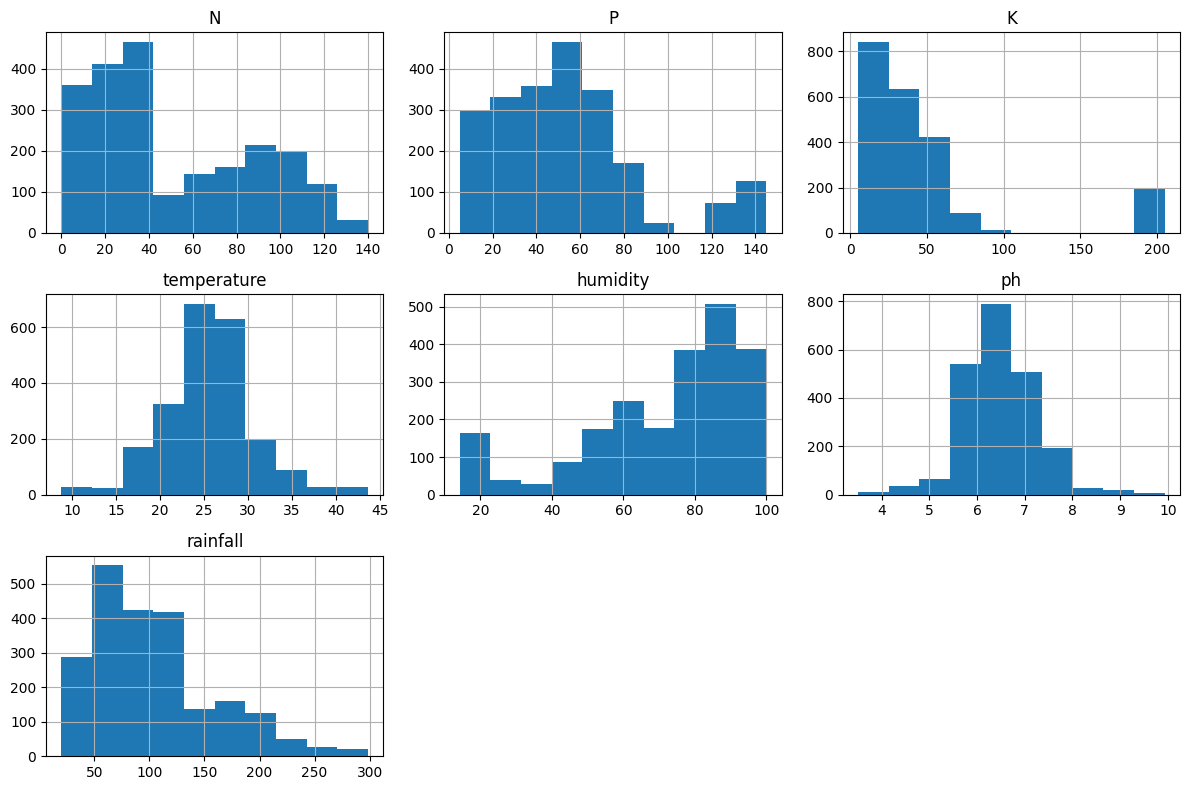

In [110]:
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

<span style="color:green; font-weight:bold">Below are the observations from the histograms of the dataset's features. These plots help us understand the distribution, skewness, and data range for each input feature:<span>

---

#### 1. **N (Nitrogen)**
- **Shape**: Bimodal distribution
- **Observation**: Primary peak at low nitrogen levels (0-40 units) while Secondary peak at high nitrogen levels around 100 units.
- **Insight**: InIndicates two distinct crop groups:

            Low-N crops (legumes like beans/peas that fix nitrogen)
            
            High-N crops (leafy greens like spinach/cabbage)
            
            Most values concentrated in 20-80 units range

#### 2. **P (Phosphorus)**
- **Shape**: Right-skewed distribution
- **Observation**: Peak at low-mid range (20-80 units).
- **Insight**: Phosphorus is also distributed moderately with a few higher values, suggesting good consistency in soil samples.

#### 3. **K (Potassium)**
- **Shape**: **BiModal**
- **Observation**: A large number of samples have potassium close to 0, with another small peak near 200.
- **Insight**: Indicates a bimodal distribution — possibly reflecting two groups of crops: some requiring minimal potassium, others requiring high levels.

#### 4. **Temperature**
- **Shape**: Approximately normal
- **Observation**: Values cluster between 22°C and 30°C.
- **Insight**: Ideal temperature range for most crops. No major outliers.

#### 5. **Humidity**
- **Shape**: Right-skewed
- **Observation**: Values peak around 80–90%.
- **Insight**: Reflects a humid climate—likely tropical/subtropical—suitable for many Indian crops.

#### 6. **pH**
- **Shape**: Normal distribution
- **Observation**: Most values fall between 5.5 and 7.5.
- **Insight**: Neutral to slightly acidic soil, optimal for a wide variety of crops.

#### 7. **Rainfall**
- **Shape**: left-skewed
- **Observation**: Most values lie between 50 and 150 mm.
- **Insight**: Indicates most crops require moderate rainfall, with a few exceptions needing much more.

---


<span style="color:green; font-weight:bold">Most features are well-distributed, but **Potassium**, **Humidity**, and **Rainfall** are **right-skewed**, meaning normalization will be important before training the model.
</span>


#### 3.3 Correlation Heatmap


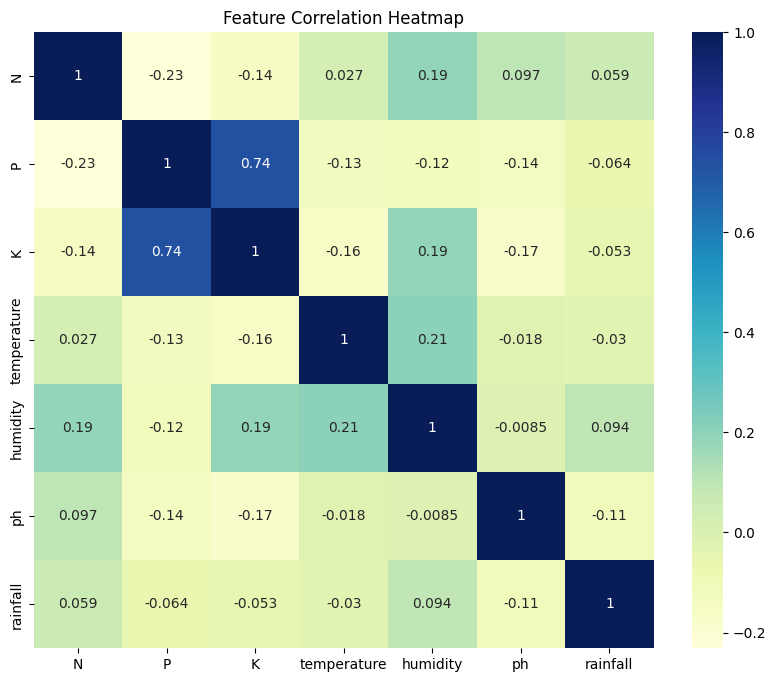

In [111]:
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Feature Correlation Heatmap")
plt.show()

<span style="color:green; font-weight:bold">With just 7 features and mostly weak correlations except one at 0.74, dimensionality reduction is not strictly necessary and might not add much value.</span>

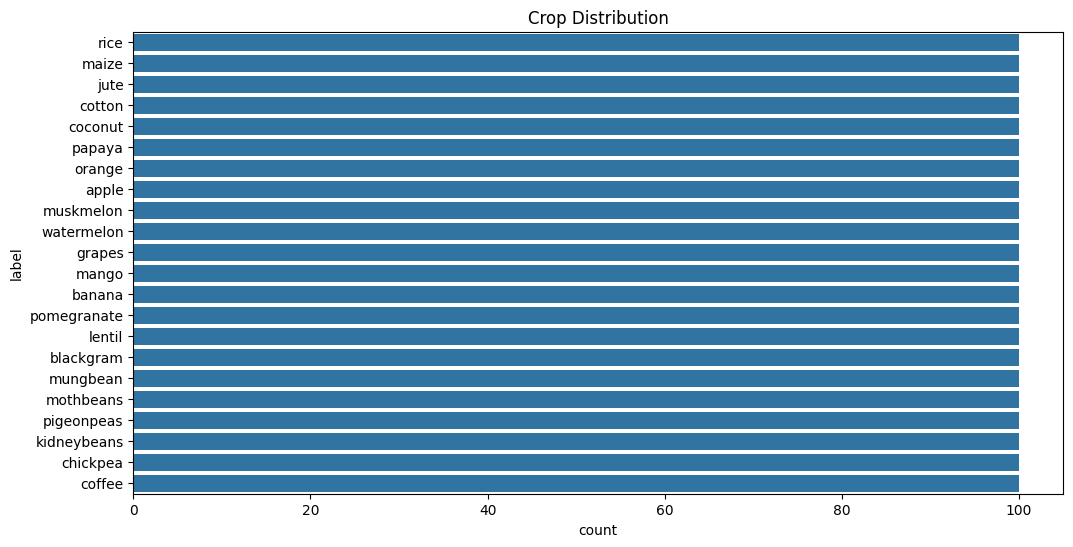

In [112]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index)
plt.title("Crop Distribution")
plt.show()


In [113]:
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


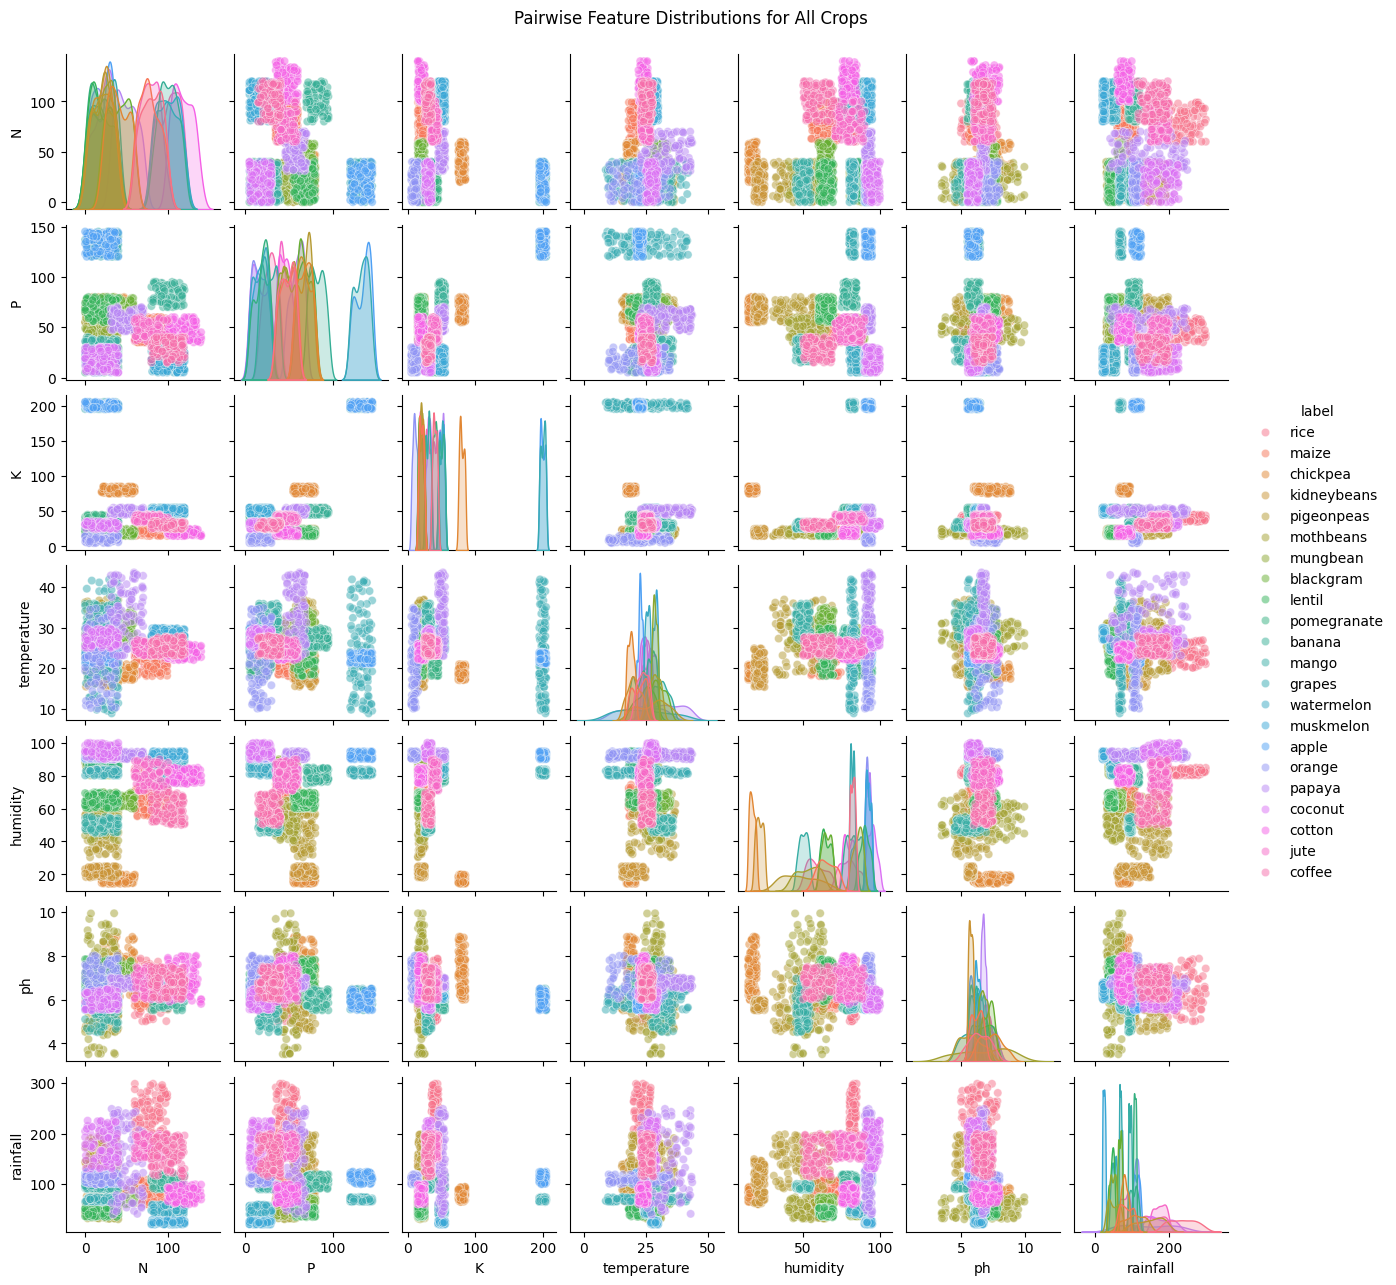

In [114]:
sns.pairplot(df, hue='label', plot_kws={'alpha': 0.5}, height=1.8)
plt.suptitle("Pairwise Feature Distributions for All Crops", y=1.02)
plt.show()

<span style="color:green; font-weight:bold">Data Insights from Feature Distributions and Pairwise Plots</span>

### Nutrient Patterns
- **Phosphorus (P)** and **Potassium (K)** exhibit distinct crop-specific clusters.
  **Potassium (K)**, in particular, shows **discrete value bands**, suggesting segmented or categorical behavior in data collection.
- **Nitrogen (N)** varies widely across samples, but shows **significant overlap between crops**, implying less utility for direct class separation.

### Climate & Soil Features
- **Temperature**, **Humidity**, **Rainfall**, and **pH** demonstrate **strong crop preferences**, forming well-separated clusters in feature space.
- **Tropical crops** (e.g., banana, coconut, mango) cluster in regions with **higher temperature, humidity, and rainfall**.
- In contrast, **dry-region crops** (e.g., chickpea, lentil, kidneybeans) are found in **lower humidity and rainfall zones**, reflecting their environmental requirements.

### Multivariate Separability
- The **pairwise plot** shows that many crops are **well-separated when multiple features are considered simultaneously**.
- This multifeature separation suggests that **classification models can leverage these interactions effectively** for accurate predictions.

<span style="color:green; font-weight:bold">Conclusion: Many crops show clear separability across combinations of features, indicating high potential for classification performance.</span>



## 3. Data Preprocessing
We encode the categorical target variable, and scale features as needed for deep learning models.


In [115]:
label_encoder = LabelEncoder()
df['crop_encoded'] = label_encoder.fit_transform(df['label'])

In [116]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
y = df['crop_encoded']

In [117]:
X=df[features]

In [118]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [119]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [120]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

print(f"Training shape: {X_train.shape}, {y_train_cat.shape}")
print(f"Testing shape: {X_test.shape}, {y_test_cat.shape}")


Training shape: (1760, 7), (1760, 22)
Testing shape: (440, 7), (440, 22)


## 4. Model Building with Keras

<span style="color:green; font-weight:bold">We design a feedforward neural network using Keras to classify crops based on input conditions. Keras Tuner is used to find the optimal hyperparameters.</span>


In [121]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        units=hp.Int('input_units', min_value=64, max_value=256, step=64),
        input_shape=(X_train.shape[1],),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 2 hidden layers
        model.add(Dense(
            units=hp.Int(f'hidden_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [122]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='tuning',
    project_name='crop_recommendation'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Starting hyperparameter search...")
tuner.search(
    X_train, y_train_cat,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

# Get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal hyperparameters:
- Input units: {best_hps.get('input_units')}
- Number of layers: {best_hps.get('num_layers')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Build best model
model = tuner.hypermodel.build(best_hps)

# %% [code]
# Train final model
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ],
    verbose=1
)

Trial 90 Complete [00h 00m 04s]
val_accuracy: 0.9857954382896423

Best val_accuracy So Far: 0.9886363744735718
Total elapsed time: 00h 03m 13s

Optimal hyperparameters:
- Input units: 256
- Number of layers: 3
- Learning rate: 0.01

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4572 - loss: 1.9372 - val_accuracy: 0.8182 - val_loss: 1.0413
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7974 - loss: 0.5789 - val_accuracy: 0.8523 - val_loss: 0.6511
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8783 - loss: 0.4005 - val_accuracy: 0.8523 - val_loss: 0.4847
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9072 - loss: 0.2951 - val_accuracy: 0.8977 - val_loss: 0.3014
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9189 - loss: 0.2497 - val_accuracy: 0.9233 - val_loss: 0.2181
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9123 - loss: 0.2871 - val_accuracy: 0.8835 - val_loss: 0.2847
Epo

In [127]:
# Build best model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,684 (514.39 KB)

 Trainable params: 43,574 (170.21 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 87,150 (340.43 KB)

### Model Summary
- The model uses **Batch Normalization** and **Dropout** after each Dense layer to improve generalization and training stability.
- **Three hidden layers** provide increasing depth and representational capacity.
- The **output layer** uses a softmax activation for **multi-class classification** across 22 crop categories.
- The model is relatively compact and lightweight, making it potentially suitable for deployment on low-resource devices.


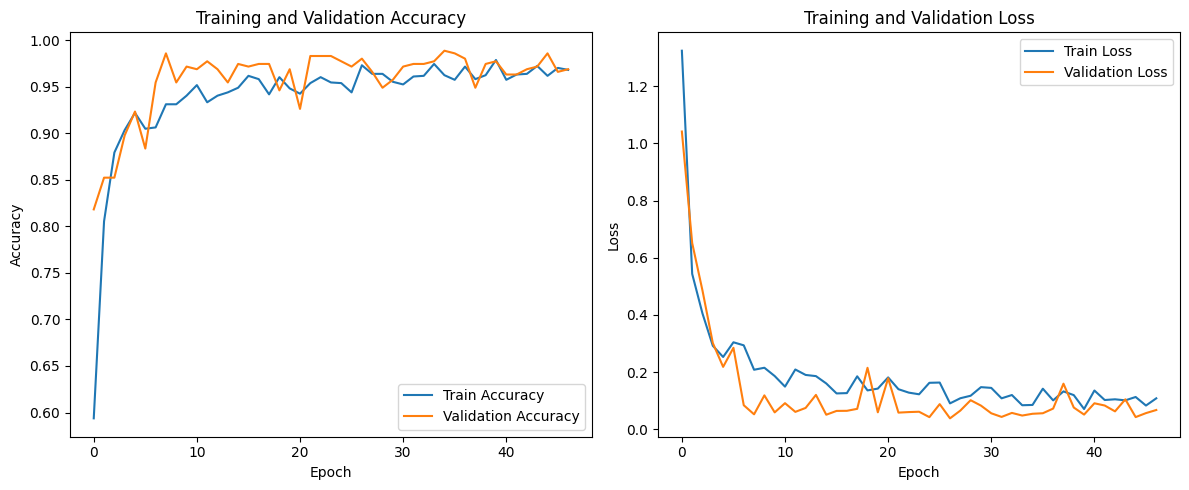

In [129]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()



The training and validation curves show that the model performs exceptionally well. Training accuracy rapidly improves and stabilizes around 97–98%, while validation accuracy closely follows, reaching up to 99%. Similarly, both training and validation losses drop sharply early on and remain low throughout, with validation loss even slightly lower at times which is a sign of strong regularization and generalization. <span style="color:green; font-weight:bold">Conclusively, the model exhibits high accuracy and robust learning behavior, indicating it is well-suited for reliable crop classification on unseen data.</span>

In [131]:
# %% [code]
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))




Test Accuracy: 0.9909
Test Loss: 0.0323
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      0.95      0.97        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      0.95      0.97        20
       mango       0.95      1.00      0.98        20
   mothbeans       1.00      0.95      0.97        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      

## 4. Final Evaluation & Insights

- The model achieves **99.09% test accuracy**, with strong class-wise metrics.
- 16 out of 22 crops are **perfectly predicted** on all metrics.
- The few minor misclassifications occurred among crops with similar climatic/nutrient needs (e.g., maize vs. lentil, coconut vs. banana).
- This suggests the model has learned meaningful crop-environment relationships, and can be used for practical crop recommendation.


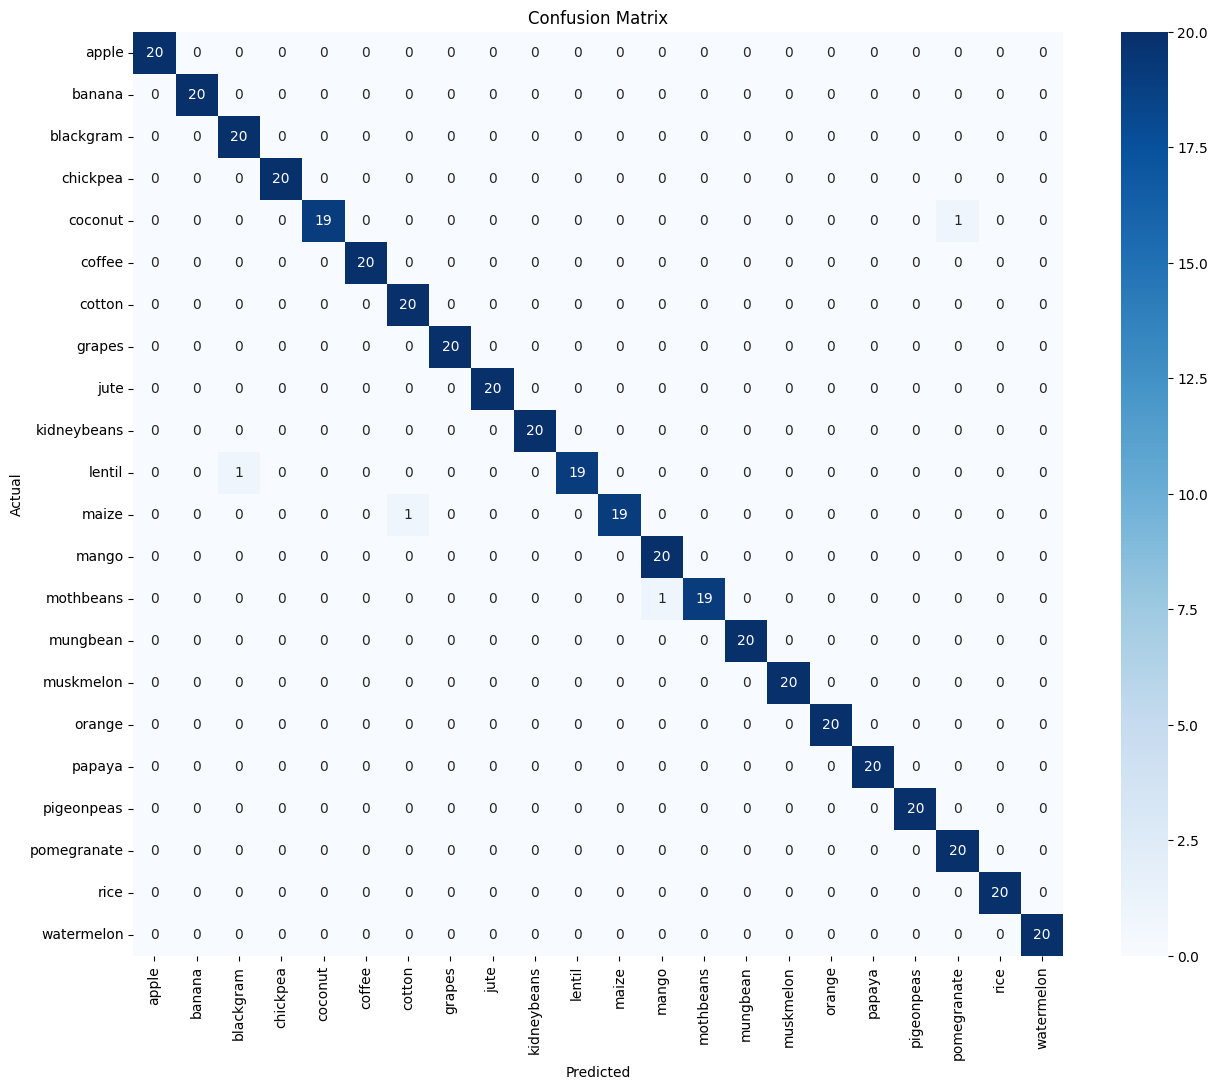

In [135]:
# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

The confusion matrix shows that the crop classification model performs exceptionally well, achieving an overall accuracy of **99.1%**, with **436 correct predictions out of 440**. Most crops such as apple, banana, grapes, jute, mungbean, rice, and watermelon are classified perfectly, with **no misclassifications**. Only **4 misclassifications** occur in total: one lentil sample was predicted as maize, one maize sample as lentil, one coconut as pomegranate, and one mothbeans as lentil. These few errors likely stem from similarities in environmental or nutrient features shared between certain crops, especially among legumes and tropical plants. Despite these minor issues, the model demonstrates excellent class separability and generalization, making it highly effective for real-world **crop recommendation systems**.


## 5. Testing Model on random samples

In [136]:
def test_model_on_random_samples(X_test, y_test, n=5):
    indices = np.random.choice(len(X_test), size=n, replace=False)
    y_test_array = y_test.to_numpy()  # <-- Convert Series to NumPy array
    
    for i in indices:
        actual_input = X_test[i]
        features_scaled = X_test[i].reshape(1, -1)
        actual_crop = label_encoder.inverse_transform([y_test_array[i]])[0]

        probabilities = model.predict(features_scaled)[0]
        predicted_crop = label_encoder.inverse_transform([np.argmax(probabilities)])[0]
        
        print(f"Actual Crop: {actual_crop}")
        print(f"Predicted Crop: {predicted_crop}")
        print("Top 3 Probabilities:")
        top3_idx = probabilities.argsort()[-3:][::-1]
        for idx in top3_idx:
            crop = label_encoder.inverse_transform([idx])[0]
            prob = probabilities[idx]
            print(f"- {crop}: {prob:.2%}")
        print("-" * 50)
test_model_on_random_samples(X_test, y_test, n=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Crop: banana
Predicted Crop: banana
Top 3 Probabilities:
- banana: 100.00%
- pigeonpeas: 0.00%
- watermelon: 0.00%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Actual Crop: jute
Predicted Crop: jute
Top 3 Probabilities:
- jute: 92.64%
- rice: 7.27%
- coffee: 0.05%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Actual Crop: papaya
Predicted Crop: papaya
Top 3 Probabilities:
- papaya: 100.00%
- jute: 0.00%
- coconut: 0.00%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Actual Crop: jute
Predicted Crop: jute
Top 3 Probabilities:
- jute: 99.63%
- coffee: 0.19%
- rice: 0.15%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Actual Crop: orange
Predicted Crop: orange
Top 3 Probabilities:
- orange: 99.99%
- mungbean: 0.01%
- cotton: 0.00%
-------------------------------------------------

## 6. Conclusion
In this project, a deep learning model was developed for multi-class crop classification using environmental and soil data. The model achieved outstanding performance, with a validation accuracy of ~99% and a test accuracy of 99.09%, as well as strong precision, recall, and F1-scores across all 22 crop categories. The confusion matrix confirms that the model consistently distinguishes between different crops with minimal misclassification. Moreover, training and validation loss curves indicate excellent convergence and no signs of overfitting, which highlights the effectiveness of the model's architecture, regularization (via dropout and batch normalization), and hyperparameter tuning.

### Future Improvements
- To enhance this project further, the following improvements could be considered:

- Larger and Diverse Dataset: Incorporate more samples and diverse geographical regions to improve model robustness and generalizability.

- Hyperparameter Optimization: Use advanced techniques like Bayesian Optimization or Genetic Algorithms for more refined tuning.

- Explainability Tools: Integrate model explainability tools (e.g., SHAP, LIME) to understand feature contributions and build user trust.

- Ensemble Models: Combine multiple models (e.g., CNN + Gradient Boosting) to reduce bias and improve classification accuracy.

- Real-time Deployment: Deploy the model in a mobile or web application for real-time farmer decision support.

- Multi-Seasonal Analysis: Train models that adapt to seasonal variations, improving year-round prediction capabilities.